In [1]:
from common import *
from helpers import *
import json
import logging
import os
import itertools
import numpy as np

logger = logging.getLogger(__name__)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "WARNING"))

RK Toolkit 0.0.1b


### Preprocessing

In [2]:
data = make_df_from_sheet("data/Sales Data Dendogram.xlsx")
df = preprocess2(data)
df = df.head(n=10)
df

,order_id,total_sales,discount,total_quantity,total_profit,postal_code,cateogry_embedding,subcategory_embedding,returns,ship_mode_embedding,country,state,region,city
0,CA-2014-100006,377.970,0.0,3,109.6113,10024,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0,"[0, 0, 0, 1]",United States,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0]",New York City
1,CA-2014-100090,699.192,0.4,9,-19.0890,94122,"[1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0, 0, 0, 2]",United States,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1]",San Francisco
2,CA-2014-100293,91.056,0.2,6,31.8696,32216,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,"[0, 0, 0, 1]",United States,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]",Jacksonville
3,CA-2014-100328,3.928,0.2,1,1.3257,10024,"[0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0, 0, 0, 1]",United States,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0]",New York City
4,CA-2014-100363,21.376,0.4,5,7.7192,85301,"[0, 2, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",0,"[0, 0, 0, 2]",United States,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1]",Glendale
5,CA-2014-100391,14.620,0.0,2,6.7252,10035,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,"[0, 0, 0, 1]",United States,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0]",New York City
6,CA-2014-100678,697.074,0.9,11,61.7937,77095,"[1, 2, 1]","[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0, 0, 0, 4]",United States,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0]",Houston
7,CA-2014-100706,129.440,0.0,8,17.7202,22153,"[1, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[0, 0, 2, 0]",United States,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0]",Springfield
8,CA-2014-100762,508.620,0.0,11,219.0774,49201,"[0, 4, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, ...",0,"[0, 0, 0, 4]",United States,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0]",Jackson
9,CA-2014-100860,18.750,0.0,5,9.0000,91767,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,"[0, 0, 1, 0]",United States,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1]",Pomona


In [3]:
numeric_columns=["total_sales", "discount", "total_quantity", "total_profit"]
embedding_columns = ["region", "state","cateogry_embedding", "subcategory_embedding", "ship_mode_embedding"]
from sklearn.preprocessing import StandardScaler, MinMaxScaler
df[numeric_columns] = StandardScaler().fit_transform(df[numeric_columns])
df[numeric_columns] = MinMaxScaler().fit_transform(df[numeric_columns])

if "postal_code" in df:
    del df["postal_code"]

In [4]:
import matplotlib
from common import *

class BaseOntologyTransform2():
    
    def __init__(self, mapping, lens="root", color_decay_rate=.1):
        self.mapping = mapping
        self.lens = lens
        self.cmap = matplotlib.cm.get_cmap('Spectral')
        self.color_decay_rate = color_decay_rate

    def transform(self, X):
        H = Graph()
        H.add_vertex(Vertex(self.lens))
        return self._convert(X, H, self.mapping, parent=self.lens, level=1)

    def _convert(self, X, H, hmap=None, parent=None, level=0, color=None, lens="root"):
        count = 0
        for k, v in hmap.items():
            if level == 1:
                color = np.array(self.cmap(count/len(hmap.keys())))
            value = X[k] if k in X else None
            color[3] *= 1- self.color_decay_rate
            nodes = []
            if isinstance(value, list):
                for i, vv in enumerate(value):
                    nid = "{}_{}".format(k, i)
                    node = Vertex(id=nid, attributes={"color": color}, value=vv)
                    H.add_vertex(node)
                    H.add_edge(Edge(u=parent, v=nid))
            node = Vertex(id=k, attributes={"color": color}, value=value)
            H.add_vertex(node)
            H.add_edge(Edge(u=parent, v=k))
            self._convert(X, H, v, parent=k, level=level+1, color=color)
            count+=1
        return H

### Embed Row Into Ontological Heirarchy

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: draw_g() got an unexpected keyword argument 'raw'

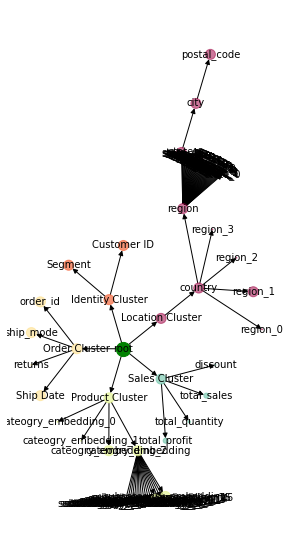

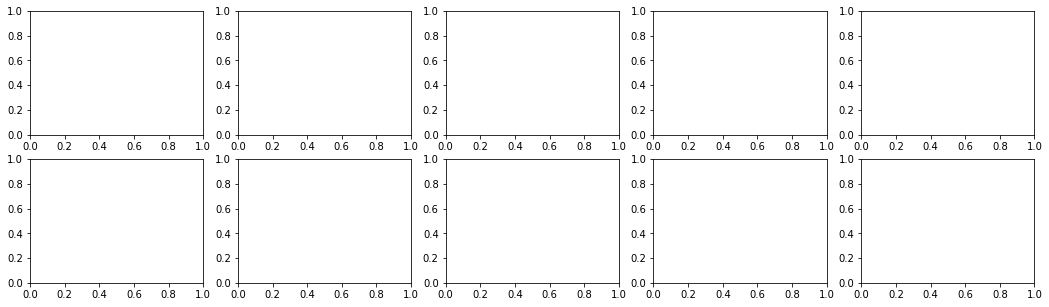

In [5]:
hmap = json.load(open("data/heirarchy2.json", "r"))
hft = BaseOntologyTransform2(mapping=hmap)
mdist = mahalanobis(df[numeric_columns], df[numeric_columns])
mdist = (mdist - mdist.min()) / (mdist.max() - mdist.min())

graphs = []
for i, row in df.iterrows():
    g = hft.transform(row)
    g.id = i
    graphs.append(g)
    if i > 10:
        break
        
distances = compute_distances(graphs, mdist, np.array([.5, .5]))


fig, ax = plt.subplots(figsize=(5,10))
draw_g(graphs[0], ax=ax, with_labels=True, minsize=1, alpha=100, emult=2, make_axis=False)  
visualize_10(graphs, raw=True, minsize=20, alpha=100, emult=4, with_labels=False)

print("Average similarity of graphs pre filter: {}".format(1 - np.mean(distances)))

### Build Untuned R-K Pipeline

In [ ]:
filters, linkers = {}, {}
for k, v in graphs[0].nodes.items():
    if 'value' in v and isinstance(v['value'], numbers.Number):
        filters[k] = RangeFilter(min=0, max=1)        
linkers['root'] = SimpleChildLinker()

In [ ]:
rkmodels = []
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers)

for i, row in df.iterrows():
    g = hft.transform(row)
    g = pipeline.transform(g)
    g.id = i
    rkmodels.append(g)
    if i > 10:
        break

mm = [m.get() for m in rkmodels]
for i in range(len(rkmodels)):
    mm[i].id = rkmodels[i].id
            
distances = compute_distances(mm, mdist, w=[.5,.5])
visualize_10(rkmodels, minsize=20, alpha=200, emult=4, with_labels=False)
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

### Train the model

In [ ]:
import nevergrad as ng
from concurrent import futures
import time

w0 = pipeline.get_w()
    
class ObjectiveFunction():
    
    def __init__(self, pipeline, sample_size):
        self.pipeline = pipeline
        self.sample_size = sample_size
        
    def evaluate(self, w):
        pupdate = self.pipeline.remap(w, w0[1])
        models = []
        sample = df.sample(n=self.sample_size)
        for i, row in sample.iterrows():
            g = hft.transform(row)
            g = pupdate.transform(g)
            g.id = i
            models.append(g)
                
        mm = [m.get() for m in models]
        for i in range(len(models)):
            mm[i].id = models[i].id
            
        distances = compute_distances(mm, mdist, [1, 0])
        c = 1 - np.mean(distances)
        return c

def train(iterations=2000, batch_size=10):
    loss_history = []
    optimizer = ng.optimizers.NGOpt(parametrization=len(w0[0]), budget=iterations, num_workers=5)
    prev_time = None
    start = time.time()
    ofunc = ObjectiveFunction(pipeline, batch_size)
    for i in range(optimizer.budget):
        x = optimizer.ask()
        loss = ofunc.evaluate(*x.args, **x.kwargs)
        if i % 100 == 0:
            now = time.time()
            if prev_time is not None:
                print("Iteration: {:05d}. Loss: {:.08f}. ITime {:.02f} seconds. Total time: {:.02f}".format(i, loss, now - prev_time, now-start))
            prev_time = now
        loss_history.append(loss)
        optimizer.tell(x, loss)
    
    recommendation = optimizer.provide_recommendation()
    return recommendation.value, loss_history

In [ ]:
trained_weights, loss_history = train()

In [ ]:
show(trained_weights, loss_history)

In [ ]:
from collections import defaultdict

class GraphCompressor():
    
    def transform(self, G):
        return self._compress_unconnected_nodes(G)
        
    def _compress_unconnected_nodes(self, g):
        ncomp = defaultdict(set)
        for n in g.nodes:
            if g.degree[n] == 1 and len(g.get_children(n)) == 0:
                for a in g.predecessors(n):
                    ncomp[a].add(n)

        arr = []
        for n,v in ncomp.items():
            arr.extend(v)
        gm = GraphMask(nmasks=arr).fit(g)
        for n,v in ncomp.items():
            name = "Disconnected {}".format(n)
            pred = list(gm.predecessors(n))
            col = 'black'
            if len(pred) > 0:
                col = g.nodes[n].get('color', 'black')
            vv = Vertex(name, attributes={"clustered_ref": name, 'color':  col})
            gm.add_vertex(vv)
            gm.add_edge(Edge(n, name))
        return gm

In [ ]:
from rktoolkit.visualizers.networkx.dendrogram import hierarchy_pos
import math
import numbers
import matplotlib.pyplot as plt 

def draw_rkmodel(model, ax=None, with_labels=True, minsize=100, alpha=300, emult=2, make_axis=False, width=2*math.pi, vert_gap=0.2, font_size=10):
    
    if make_axis:
        fig, ax = plt.subplots(figsize=(5, 20)) 
    if ax is None:
        ax = plt.gca()  
        
    pos = hierarchy_pos(model.G, 'root', width = width, xcenter=0, vert_gap=vert_gap)   
    new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
    cols = [ n[1].get('color', 'black') for n in list(model.G.nodes.items())]
    masked_model = model.get()
    cols = [ n[1].get('color', 'black') for n in list(masked_model.nodes.items())]
    sizes = []
    for n in list(masked_model.nodes.items()):
        v = n[1].get("value",1)
        if not isinstance(v, numbers.Number):
            v = 0
        v+=1
        sizes.append(v)
    sizes = np.array(sizes)
    sizes = sizes ** 2 #np.exp(sizes)
    sizes = (sizes - sizes.min()) / (sizes.max()-sizes.min())
    sizes *= alpha
    sizes += minsize
    sizes = np.where(np.isnan(sizes), minsize, sizes)
    
    nx.draw(masked_model, pos=new_pos, with_labels=with_labels, font_size=font_size, ax=ax, node_color = cols, node_size=sizes)
    nx.draw_networkx_nodes(model.G, pos=new_pos, nodelist = ['root'], node_color = 'green', ax=ax, node_size = sizes.max()*emult)

def draw_g(G, ax=None, with_labels=True, minsize=100, alpha=300, emult=2, make_axis=False, width=2*math.pi, vert_gap=0.2, font_size=10):
    if make_axis:
        fig, ax = plt.subplots(figsize=(10, 20))
    if ax is None:
        ax = plt.gca()
    pos = hierarchy_pos(G, 'root', width = width, xcenter=0, vert_gap=vert_gap)
    new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
    #new_pos = pos
    cols = [ n[1].get('color', 'black') for n in list(G.nodes.items())]
    sizes = []
    for n in list(G.nodes.items()):
        v = n[1].get("value",0)
        if not isinstance(v, numbers.Number):
            v = 1
        v+=1
        sizes.append(v)
    sizes = np.array(sizes)
    sizes = sizes ** 5 #np.exp(sizes)
    sizes = (sizes - sizes.min()) / (sizes.max()-sizes.min())
    sizes *= alpha
    sizes += minsize
    sizes = np.where(np.isnan(sizes), minsize, sizes)
    nx.draw(G, pos=new_pos, with_labels=with_labels, font_size=font_size, node_size=sizes, ax=ax, node_color = cols)
    nx.draw_networkx_nodes(G, pos=new_pos, nodelist = ['root'], node_color = 'green', ax=ax, node_size = sizes.max()*emult)
    
def visualize_10(graphs, raw=False, *args, **kwargs):
    fig, ax = plt.subplots(2,5, figsize=(18,10))
    for i in range(10):
        j, k = i % 5, int(i/5)
        if raw:
            draw_g(graphs[i], ax=ax[k][j], *args, **kwargs)
        else:
            draw_rkmodel(graphs[i], ax=ax[k][j], *args, **kwargs)
        ax[k][j].set_title("{}: M Dist: {:.02f}".format(i, mdist[i]))

In [ ]:
def show(trained_weights, loss_history):
    rkmodels = []
    pupdate = pipeline.remap(trained_weights, w0[1])
    for i, row in df.iterrows():
        g = hft.transform(row)
        g = pupdate.transform(g)
        g.id = i
        rkmodels.append(g)
        if i > 10:
            break
            
    mm = [m.get() for m in rkmodels]
    for i in range(len(rkmodels)):
        mm[i].id = rkmodels[i].id
        
    distances = compute_distances(mm, mdist, [.5, .5])
    fig, ax = plt.subplots(figsize=(5,10))
    draw_g(rkmodels[0].G, ax=ax, with_labels=True, minsize=1, alpha=100, emult=2, make_axis=False)
    plt.savefig("base_model.png",  dpi = 300, bbox_inches="tight")

    visualize_10(rkmodels, minsize=20, alpha=100, emult=2, with_labels=False, make_axis=False)
    plt.savefig("uncompressed_models.png",  dpi = 300, bbox_inches="tight")

    plt.gca()
    plt.show()
    compressed_models = [GraphCompressor().transform(m.get()) for m in rkmodels]
    visualize_10(compressed_models, minsize=20, alpha=100, emult=2, with_labels=False, make_axis=False, raw=True)
    plt.savefig("compressed_models.png",  dpi = 300, bbox_inches="tight")

    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_title("Loss Over Time")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.plot(loss_history)
    plt.show()
    plt.savefig("loss_over_time.png",  dpi = 300, bbox_inches="tight")
    
show(trained_weights, loss_history)

In [ ]:
show(trained_weights, loss_history)